In [1]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import datetime

np.random.seed(1234)
torch.manual_seed(1234)

In [2]:
# Read and clean stock + climate Data

raw_stock_data = pd.read_csv('Daily Prices_ICCO (1).csv')
raw_stock_data['Date'] = pd.to_datetime(raw_stock_data['Date'], dayfirst=True)
raw_stock_data['Price'] = raw_stock_data['ICCO daily price (US$/tonne)'].str.replace(',', '').astype(float)
raw_stock_data = raw_stock_data.drop(columns=['ICCO daily price (US$/tonne)'])
raw_stock_data = raw_stock_data.sort_values(by='Date')

raw_climate_data = pd.read_csv('Ghana_data (1).csv')
raw_climate_data['Date'] = pd.to_datetime(raw_climate_data['DATE'])
raw_climate_data = raw_climate_data.drop(columns=['DATE'])
raw_climate_data = raw_climate_data.sort_values(by='Date')  

raw_climate_data['TMAX'] = raw_climate_data['TMAX'].interpolate(method='linear')
raw_climate_data['TMIN'] = raw_climate_data['TMIN'].interpolate(method='linear') 
raw_climate_data['TAVG'] = raw_climate_data['TAVG'].interpolate(method='linear') 
raw_climate_data['PRCP'] = raw_climate_data['PRCP'].fillna(0.0)



In [3]:
# Scaling Data since RNN is sensative to the scale of its inputs (due to gradient exploding/vanishing)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
raw_stock_data['Price'] = scaler.fit_transform(raw_stock_data['Price'].values.reshape(-1, 1))

scaler = StandardScaler()
raw_climate_data['TMAX'] = scaler.fit_transform(raw_climate_data['TMAX'].values.reshape(-1, 1))

scaler = StandardScaler()
raw_climate_data['TMIN'] = scaler.fit_transform(raw_climate_data['TMIN'].values.reshape(-1, 1))

scaler = StandardScaler()
raw_climate_data['TAVG'] = scaler.fit_transform(raw_climate_data['TAVG'].values.reshape(-1, 1))

scaler = StandardScaler()
raw_climate_data['PRCP'] = scaler.fit_transform(raw_climate_data['PRCP'].values.reshape(-1, 1))

kotoka_climate_data = raw_climate_data[raw_climate_data['STATION'] == 'GHM00065472']

avg_climate_data = raw_climate_data.groupby("Date", as_index=False)[["PRCP", "TAVG", "TMAX", "TMIN", "Date"]].mean()

In [5]:
#Split data into test and training sets

test_stock = raw_stock_data[raw_stock_data['Date'] >= pd.to_datetime("01-06-2024", dayfirst=True)]
test_climate = avg_climate_data[avg_climate_data['Date'] >= pd.to_datetime("01-06-2024", dayfirst=True)]

train_stock = raw_stock_data[raw_stock_data['Date'] < pd.to_datetime("01-06-2024", dayfirst=True)]
train_climate = avg_climate_data[avg_climate_data['Date'] < pd.to_datetime("01-06-2024", dayfirst=True)]

train_merged = train_stock.merge(train_climate, on='Date', how='inner')
test_merged = test_stock.merge(test_climate, on='Date', how='inner')

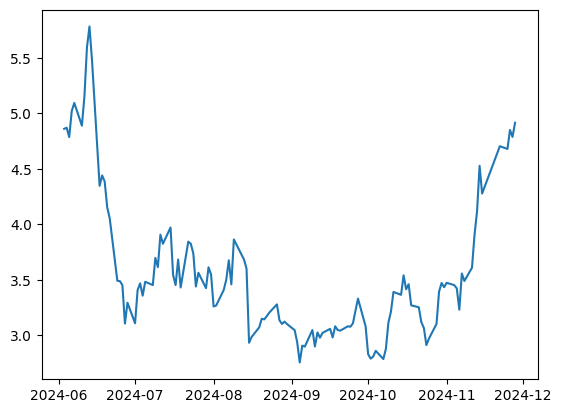

In [6]:
plt.plot(test_merged['Date'], test_merged['Price'])

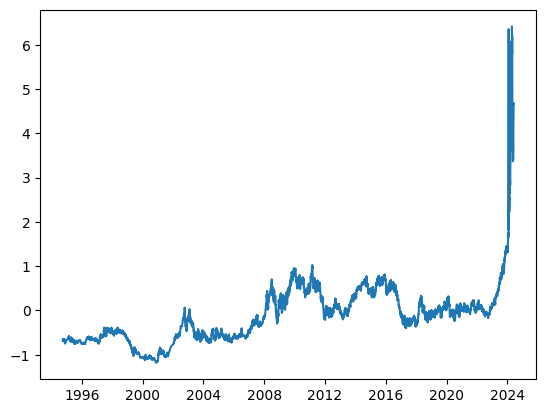

In [7]:
plt.plot(train_merged['Date'], train_merged['Price'])

In [8]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [9]:
# Create custom dataset class and StockRNN model to enable RNN training and inference
class StockDataset(Dataset):
    def __init__(self, stock_data, seq_len=30, univariate=True):
        self.univariate = univariate
        x, y = [], []
        for i in range(len(stock_data) - seq_len):
            if univariate:
                x.append(stock_data.iloc[i:i+seq_len]['Price'].values)
                y.append(stock_data.iloc[i+seq_len]['Price'])
            else:
                x.append(stock_data.iloc[i:i+seq_len][['Price', 'TAVG', 'PRCP']].values)
                y.append(stock_data.iloc[i+seq_len][['Price', 'TAVG', 'PRCP']].values)
            
            

        self.x = torch.tensor(x, dtype=torch.float32) 
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.univariate:
            return self.x[idx].unsqueeze(-1), self.y[idx] 
        else:
            return self.x[idx], self.y[idx]
        
class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=10, out_size=1):
        super(StockRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        out, _ = self.rnn(x) 
        out = self.fc(out[:, -1, :]) 

        return out


## Univariate

In [10]:
train_dataset = StockDataset(train_merged, univariate=True)
test_dataset = StockDataset(test_merged, univariate=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\aryas\AppData\Local\Temp\ipykernel_44308\1962218709.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.x = torch.tensor(x, dtype=torch.float32)


In [11]:
# Set up model, loss function and optimizer for gradient descnent training
MODEL = StockRNN(input_size=1, hidden_size=30, num_layers=3, out_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(MODEL.parameters(), lr=0.001)


In [12]:
# training RNN
MODEL.train()
for epoch in range(10):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = MODEL(x_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(-1))
        # print(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
   
    print(f'Epoch: {epoch}, Loss: {total_loss/len(train_loader)}')
    

Epoch: 0, Loss: 0.35122365945825745
Epoch: 1, Loss: 0.1666971684976934
Epoch: 2, Loss: 0.09995466932220962
Epoch: 3, Loss: 0.0786247478489731
Epoch: 4, Loss: 0.0566941855965221
Epoch: 5, Loss: 0.044546696029012275
Epoch: 6, Loss: 0.029736518689377607
Epoch: 7, Loss: 0.02588232043918277
Epoch: 8, Loss: 0.023490026397328122
Epoch: 9, Loss: 0.015250330876476844


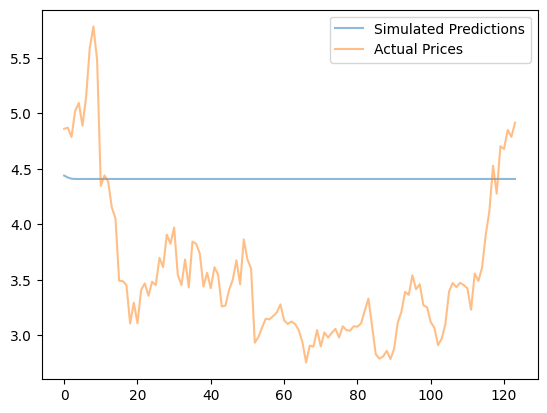

In [13]:
# Simulating forecasts using RNN for lenght of test dataset

MODEL.eval()
simulated_predictions = []

# Start with the first 30 known values (last 30 of train dataset)
current_input = torch.concat((train_dataset.x[-1].clone(), train_dataset.y[-1].clone().unsqueeze(-1))) # Clone the first sequence to avoid modifying the dataset

with torch.no_grad():
    for _ in range(len(test_dataset) + 30):  # Simulate for the remaining test data

        # Predict the next value
        next_pred = MODEL(current_input.reshape(1, -1, 1)).reshape(-1)
        simulated_predictions.append(next_pred)


        current_input = torch.cat((current_input[1:], next_pred))
        
        
# Combine the initial known values with the simulated predictions
simulated_predictions = torch.tensor(simulated_predictions).numpy().flatten()
true_prices = np.concatenate((test_dataset.x[0].numpy().flatten(), test_dataset.y.numpy()))

# Plot the simulated predictions against the actual test prices
plt.plot(simulated_predictions, label='Simulated Predictions', alpha=0.5)
plt.plot(true_prices, label='Actual Prices', alpha=0.5)
plt.legend()
plt.show()

In [14]:
MODEL.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        preds = MODEL(X_batch)
        predictions.append(preds.numpy())
        actuals.append(y_batch.numpy())
pred_train = np.concatenate(predictions)
act_train = np.concatenate(actuals)

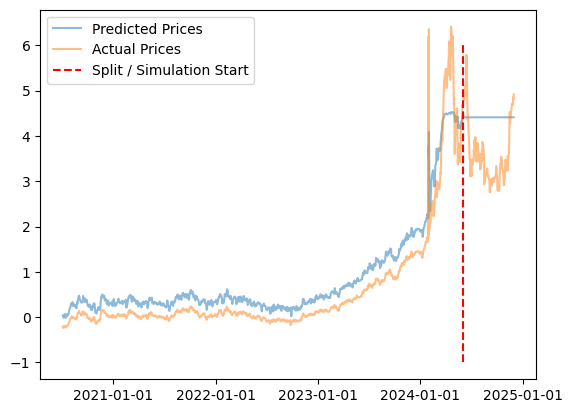

In [15]:
# Plotting model predictions against actual prices 

plt.plot(np.concatenate((train_merged["Date"][-1000:], test_merged["Date"])), np.concatenate((pred_train.flatten()[-1000:], simulated_predictions)), label='Predicted Prices', alpha=0.5)

plt.plot(np.concatenate((train_merged["Date"][-1000:], test_merged["Date"])), np.concatenate((act_train.flatten()[-1000:], true_prices)), label='Actual Prices', alpha=0.5)

plt.vlines(x = datetime.datetime(2024, 6, 1), ymin=-1, ymax=6, color='red', linestyle='--', label='Split / Simulation Start')
plt.xticks([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 1, 1), datetime.datetime(2023, 1, 1), datetime.datetime(2024, 1, 1), datetime.datetime(2025, 1, 1)]) 
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error

In [18]:
print("RMSE on training and testing data")
print(np.sqrt(mean_squared_error(act_train, pred_train)))
print(np.sqrt(mean_squared_error(simulated_predictions, true_prices)))

RMSE on training and testing data
0.30140958526094896
1.0710051028951968


## Multi-Variate

In [19]:
train_dataset = StockDataset(train_merged, univariate=False)
test_dataset = StockDataset(test_merged, univariate=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
MODEL = StockRNN(input_size=3, hidden_size=30, num_layers=3, out_size=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(MODEL.parameters(), lr=0.001)


In [21]:
MODEL.train()
for epoch in range(10):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = MODEL(x_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
   
    print(f'Epoch: {epoch}, Loss: {total_loss/len(train_loader)}')
    

Epoch: 0, Loss: 0.33271738569087844
Epoch: 1, Loss: 0.23015725599857523
Epoch: 2, Loss: 0.21868818432238757
Epoch: 3, Loss: 0.20477982922731078
Epoch: 4, Loss: 0.20146236296597064
Epoch: 5, Loss: 0.1964656102343225
Epoch: 6, Loss: 0.19114350722920076
Epoch: 7, Loss: 0.1906118772960469
Epoch: 8, Loss: 0.18928267609547167
Epoch: 9, Loss: 0.1892216865557666


In [23]:
MODEL.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        preds = MODEL(X_batch)
        predictions.append(preds.numpy())
        actuals.append(y_batch.numpy())
pred_train = np.concatenate(predictions)
act_train = np.concatenate(actuals)

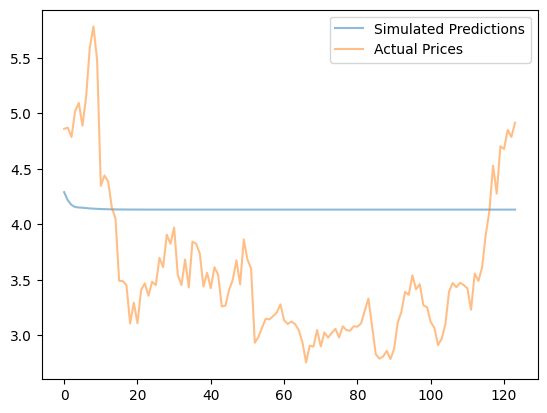

In [24]:
MODEL.eval()
simulated_predictions = []

# Start with the first 30 known values (last 30 of train dataset)
current_input = torch.concat((train_dataset.x[-1].clone(), train_dataset.y[-1].clone().unsqueeze(0))) # Clone the first sequence to avoid modifying the dataset

with torch.no_grad():
    for _ in range(len(test_dataset) + 30):  # Simulate for the remaining test data

        # Predict the next value
        next_pred = MODEL(current_input.reshape(1, -1, 3)).reshape(-1)
        simulated_predictions.append(next_pred)

        current_input = torch.cat((current_input[1:], next_pred.unsqueeze(0)))
        
        
# Combine the initial known values with the simulated predictions
simulated_predictions = torch.stack(simulated_predictions).numpy()
true_prices = np.concatenate((test_dataset.x[0].numpy(), test_dataset.y.numpy()))

# Plot the simulated predictions against the actual test prices
plt.plot(simulated_predictions[:, 0], label='Simulated Predictions', alpha=0.5)
plt.plot(true_prices[:, 0], label='Actual Prices', alpha=0.5)
plt.legend()
plt.show()

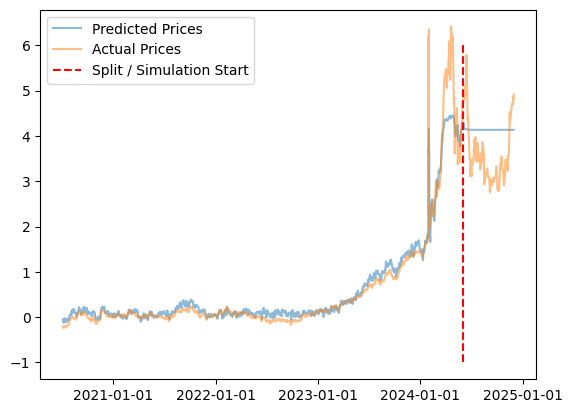

In [25]:
plt.plot(np.concatenate((train_merged["Date"][-1000:], test_merged["Date"])), np.concatenate((pred_train[-1000:, 0], simulated_predictions[:, 0])), label='Predicted Prices', alpha=0.5)

plt.plot(np.concatenate((train_merged["Date"][-1000:], test_merged["Date"])), np.concatenate((act_train[-1000:, 0], true_prices[:, 0])), label='Actual Prices', alpha=0.5)

plt.vlines(x = datetime.datetime(2024, 6, 1), ymin=-1, ymax=6, color='red', linestyle='--', label='Split / Simulation Start')
plt.xticks([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 1, 1), datetime.datetime(2023, 1, 1), datetime.datetime(2024, 1, 1), datetime.datetime(2025, 1, 1)]) 
plt.legend()
plt.show()

In [26]:
print("RMSE on training and testing data - Multivariate - all variables simualted")
print(np.sqrt(mean_squared_error(act_train[:, 0], pred_train[:, 0])))
print(np.sqrt(mean_squared_error(simulated_predictions[:, 0], true_prices[:, 0])))

RMSE on training and testing data - Multivariate - all variables simualted
0.1661493155783178
0.8680859628225996


Using Known value for temprature and Percipetation and only simulating Price

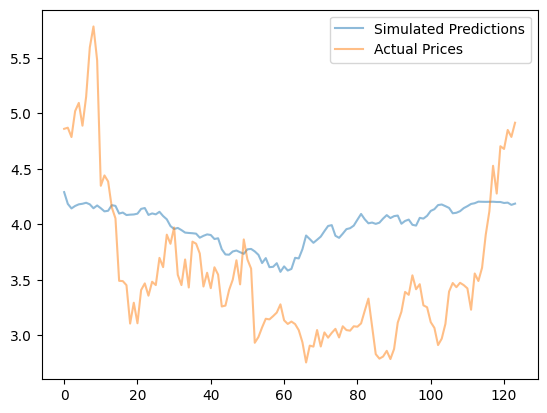

In [27]:
MODEL.eval()
simulated_predictions = []

# Start with the first 30 known values (last 30 of train dataset)
current_input = torch.concat((train_dataset.x[-1].clone(), train_dataset.y[-1].clone().unsqueeze(0)))  # Clone the first sequence to avoid modifying the dataset

with torch.no_grad():
    for i in range(-30, len(test_dataset)):  # Simulate for the remaining test data

        # Predict the next value for the variable at index 0
        next_pred = MODEL(current_input.reshape(1, -1, 3)).reshape(-1)
        
        # Modify next_pred to use true values for variables at index 1 and 2
        if i >= 0:
            true_values = test_dataset.y[i]
        else: 
            true_values = test_dataset.x[0, i+30] 
            
        next_pred[1:] = true_values[1:]  # Replace indices 1 and 2 with true values

        simulated_predictions.append(next_pred)

        # Update current_input with the new prediction
        current_input = torch.cat((current_input[1:], next_pred.unsqueeze(0)))

# Combine the initial known values with the simulated predictions
simulated_predictions = torch.stack(simulated_predictions).numpy()
true_prices = np.concatenate((test_dataset.x[0].numpy(), test_dataset.y.numpy()))

# Plot the simulated predictions against the actual test prices
plt.plot(simulated_predictions[:, 0], label='Simulated Predictions', alpha=0.5)
plt.plot(true_prices[:, 0], label='Actual Prices', alpha=0.5)
plt.legend()
plt.show()

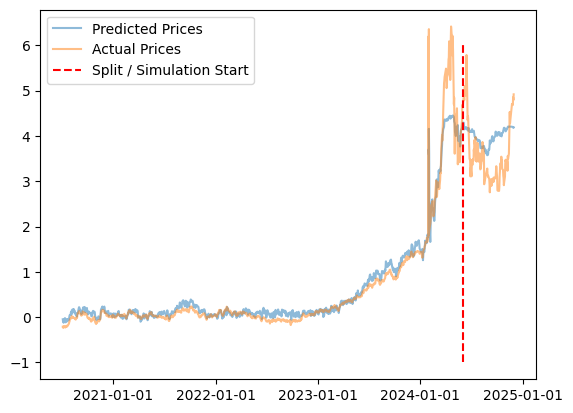

In [28]:
plt.plot(np.concatenate((train_merged["Date"][-1000:], test_merged["Date"])), np.concatenate((pred_train[-1000:, 0], simulated_predictions[:, 0])), label='Predicted Prices', alpha=0.5)

plt.plot(np.concatenate((train_merged["Date"][-1000:], test_merged["Date"])), np.concatenate((act_train[-1000:, 0], true_prices[:, 0])), label='Actual Prices', alpha=0.5)

plt.vlines(x = datetime.datetime(2024, 6, 1), ymin=-1, ymax=6, color='red', linestyle='--', label='Split / Simulation Start')
plt.xticks([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 1, 1), datetime.datetime(2023, 1, 1), datetime.datetime(2024, 1, 1), datetime.datetime(2025, 1, 1)]) 
plt.legend()
plt.show()

In [29]:
print("RMSE on training and testing data - Multivariate - only price simulated")
print(np.sqrt(mean_squared_error(act_train[:, 0], pred_train[:, 0])))
print(np.sqrt(mean_squared_error(simulated_predictions[:, 0], true_prices[:, 0])))

RMSE on training and testing data - Multivariate - only price simulated
0.1661493155783178
0.7377838396761068
